In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from datasets.nuscenes import compile_data
from datasets.nuscenes_ood import compile_data as compile_data_ood
from models.baseline import *
from models.evidential import *

import tools.loss

from time import time

In [4]:
num_workers = [1, 2, 4, 8, 16, 32, 64]
split = 'mini'
DATAROOT = "../../data/nuscenes"

In [24]:
tl, vl = compile_data(split, DATAROOT, num_workers=32, batch_size=2)

In [6]:
images, intrinsics, extrinsics, labels = tl.dataset[100]

In [7]:
from tools.utils import *
%matplotlib inline
import matplotlib.pyplot as plt

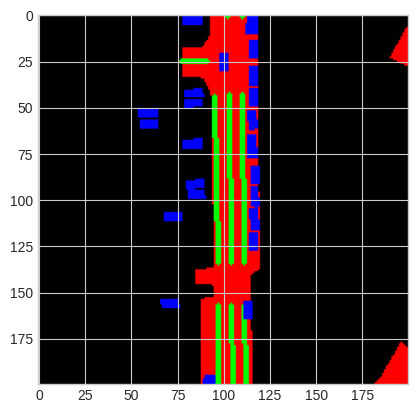

In [8]:
plt.imshow(map_rgb(torch.tensor(labels)) / 255)

In [9]:
model = Baseline([7], loss_type='focal')
model.load(torch.load("../nuscenes/fiery_baseline/9.pt"))

Loaded pretrained weights for efficientnet-b4


In [234]:
images, intrinsics, extrinsics, labels = vl.dataset[0]
intrinsics = intrinsics[None].to(7)
extrinsics = extrinsics[None].to(7)

[-33.07996016  52.21961928  62.10296571]
[-1.17933488  0.38335996 73.48679961]
[ 31.89965459 -53.28433964  61.87847212]
[ 30.33855336  66.07025417 -47.79542013]
[  0.39363153  -0.85053375 -73.98937449]
[-34.82856314 -63.55492694 -51.14859833]


In [307]:
pts = model.backbone.module.get_geometry(intrinsics, extrinsics).cpu().numpy()
pts.shape

tensor([[[[381.7794,   0.0000, 247.9846],
          [  0.0000, 381.7794,  97.9255],
          [  0.0000,   0.0000,   1.0000]],

         [[379.9252,   0.0000, 244.8801],
          [  0.0000, 379.9252, 101.4521],
          [  0.0000,   0.0000,   1.0000]],

         [[378.2542,   0.0000, 242.3905],
          [  0.0000, 378.2542, 102.6003],
          [  0.0000,   0.0000,   1.0000]],

         [[377.0225,   0.0000, 237.6338],
          [  0.0000, 377.0225, 101.8327],
          [  0.0000,   0.0000,   1.0000]],

         [[242.7663,   0.0000, 248.7659],
          [  0.0000, 242.7663,  98.5335],
          [  0.0000,   0.0000,   1.0000]],

         [[377.8542,   0.0000, 242.1759],
          [  0.0000, 377.8542, 104.3587],
          [  0.0000,   0.0000,   1.0000]]]], device='cuda:7')


(1, 6, 48, 28, 60, 3)

(-50.0, 50.0)

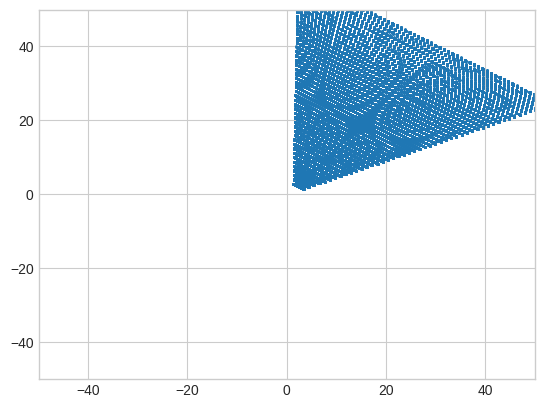

In [291]:
plt.scatter(pts[:, 0, :, :, :, 0].reshape(-1), pts[:, 0, :, :, :, 1].reshape(-1), s=1)
plt.xlim((-50, 50))
plt.ylim((-50, 50))

In [280]:
def get_extrinsics(translation, rotation):
    # pitch, yaw, roll = np.radians([rotation.pitch, rotation.yaw, -rotation.roll])
    pitch, yaw, roll = np.radians([rotation[0], rotation[1], -rotation[2]])

    cy, sy = np.cos(yaw), np.sin(yaw)
    cp, sp = np.cos(pitch), np.sin(pitch)
    cr, sr = np.cos(roll), np.sin(roll)

    R = np.array([
        [cy * cr + sy * sp * sr, -cy * sr + sy * sp * cr, sy * cp],
        [cp * sr, cp * cr, -sp],
        [-sy * cr + cy * sp * sr, sy * sr + cy * sp * cr, cy * cp]
    ])

    # t = np.array([translation.x, translation.y, translation.z]).reshape(3, 1)
    t = np.array([translation[0], translation[1], translation[2]]).reshape(3, 1)

    H = np.zeros((4, 4))
    H[0:3, 0:3] = R
    H[0:3, 3] = t[:, 0]
    H[3, 3] = 1

    return H

def from_homogeneous_matrix(H):
    # Extract the rotation matrix (3x3 upper left part)
    R = H[0:3, 0:3]

    # Extract the translation vector (3x1 upper right part)
    T = H[0:3, 3].reshape(3, 1)

    return R, T

def rotation_matrix_to_euler_angles(R):
    sy = np.sqrt(R[0, 0] * R[0, 0] + R[1, 0] * R[1, 0])
    singular = sy < 1e-6

    if not singular:
        x = np.arctan2(R[2, 1], R[2, 2])
        y = np.arctan2(-R[2, 0], sy)
        z = np.arctan2(R[1, 0], R[0, 0])
    else:
        x = np.arctan2(-R[1, 2], R[1, 1])
        y = np.arctan2(-R[2, 0], sy)
        z = 0

    # Convert to degrees
    return np.degrees([x, y, z])

def get_intrinsics():
    intrinsics = np.identity(3)
    intrinsics[0, 2] = 480 / 2.0
    intrinsics[1, 2] = 224 / 2.0
    intrinsics[0, 0] = intrinsics[1, 1] = 480 / (
            2.0 * np.tan(90 * np.pi / 360.0))

    return intrinsics

def ext_inverse(E):
    R = E[0:3, 0:3]
    T = E[0:3, 3].reshape(3, 1)
    
    # Invert the rotation matrix (which is the same as transposing it)
    R_inv = np.transpose(R)
    
    # Invert the translation vector
    T_inv = -np.dot(R_inv, T)
    
    # Combine into the inverse of the extrinsic matrix
    E_inv = np.identity(4)
    E_inv[0:3, 0:3] = R_inv
    E_inv[0:3, 3] = T_inv[:, 0]

    return E_inv

In [305]:
int = get_intrinsics()
int = int[None].repeat(1, axis=0)[None]
int = torch.tensor(int).cuda(7).float()
print(int)

tensor([[[[240.,   0., 240.],
          [  0., 240., 112.],
          [  0.,   0.,   1.]]]], device='cuda:7')


In [282]:
trans = [
    [0, 0, 2],
    [0, 0, 2],
    [0, 0, 2],
    [0, 0, 2],
    [0, 0, 2],
    [0, 0, 2],
]

rots = [
    [-90, -60, 0],
    [-90, 0, 0],
    [-90, 60, 0],
    [-90, -120, 0],
    [-90, 180, 0],
    [-90, 120, 0],
]

In [303]:
e = []

for i in range(6):
    e.append(ext_inverse(get_extrinsics(trans[i], rots[i])))
    # e.append(get_extrinsics(trans[i], rots[i]))

ext = np.stack(e)[None]
ext = torch.tensor(ext).cuda(7).float()

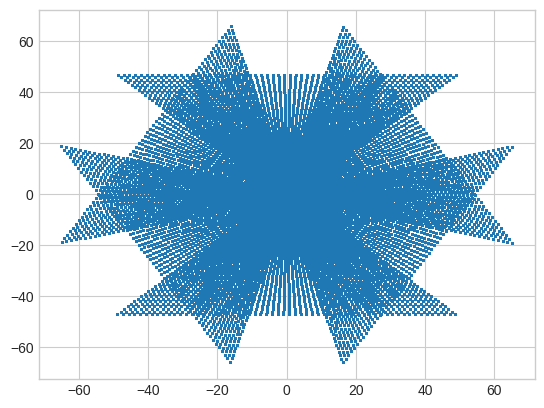

In [304]:
pts = model.backbone.module.get_geometry(int, ext).cpu().numpy()
plt.scatter(pts[:, :, :, :, :, 0].reshape(-1), pts[:, :, :, :, :, 1].reshape(-1), s=1)
# plt.xlim((-50, 50))
# plt.ylim((-50, 50))